# MNIST Digit Classification
MNIST is the "hello world" of computer vision, so this project is for me to show off my computer vision skills on a widely known and straightforward dataset. Here's a rundown of the task:
- Classify a 28x28 pixel greyscale image of a handwritten digit into the class corresponding to its value {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
- Train on a set of 60,000 images, test on a set of 10,000

In [4]:
import numpy as np
import struct
from array import array
from os.path  import join
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

# Provided data loader found at https://www.kaggle.com/code/hojjatk/read-mnist-dataset
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

## Loading the images

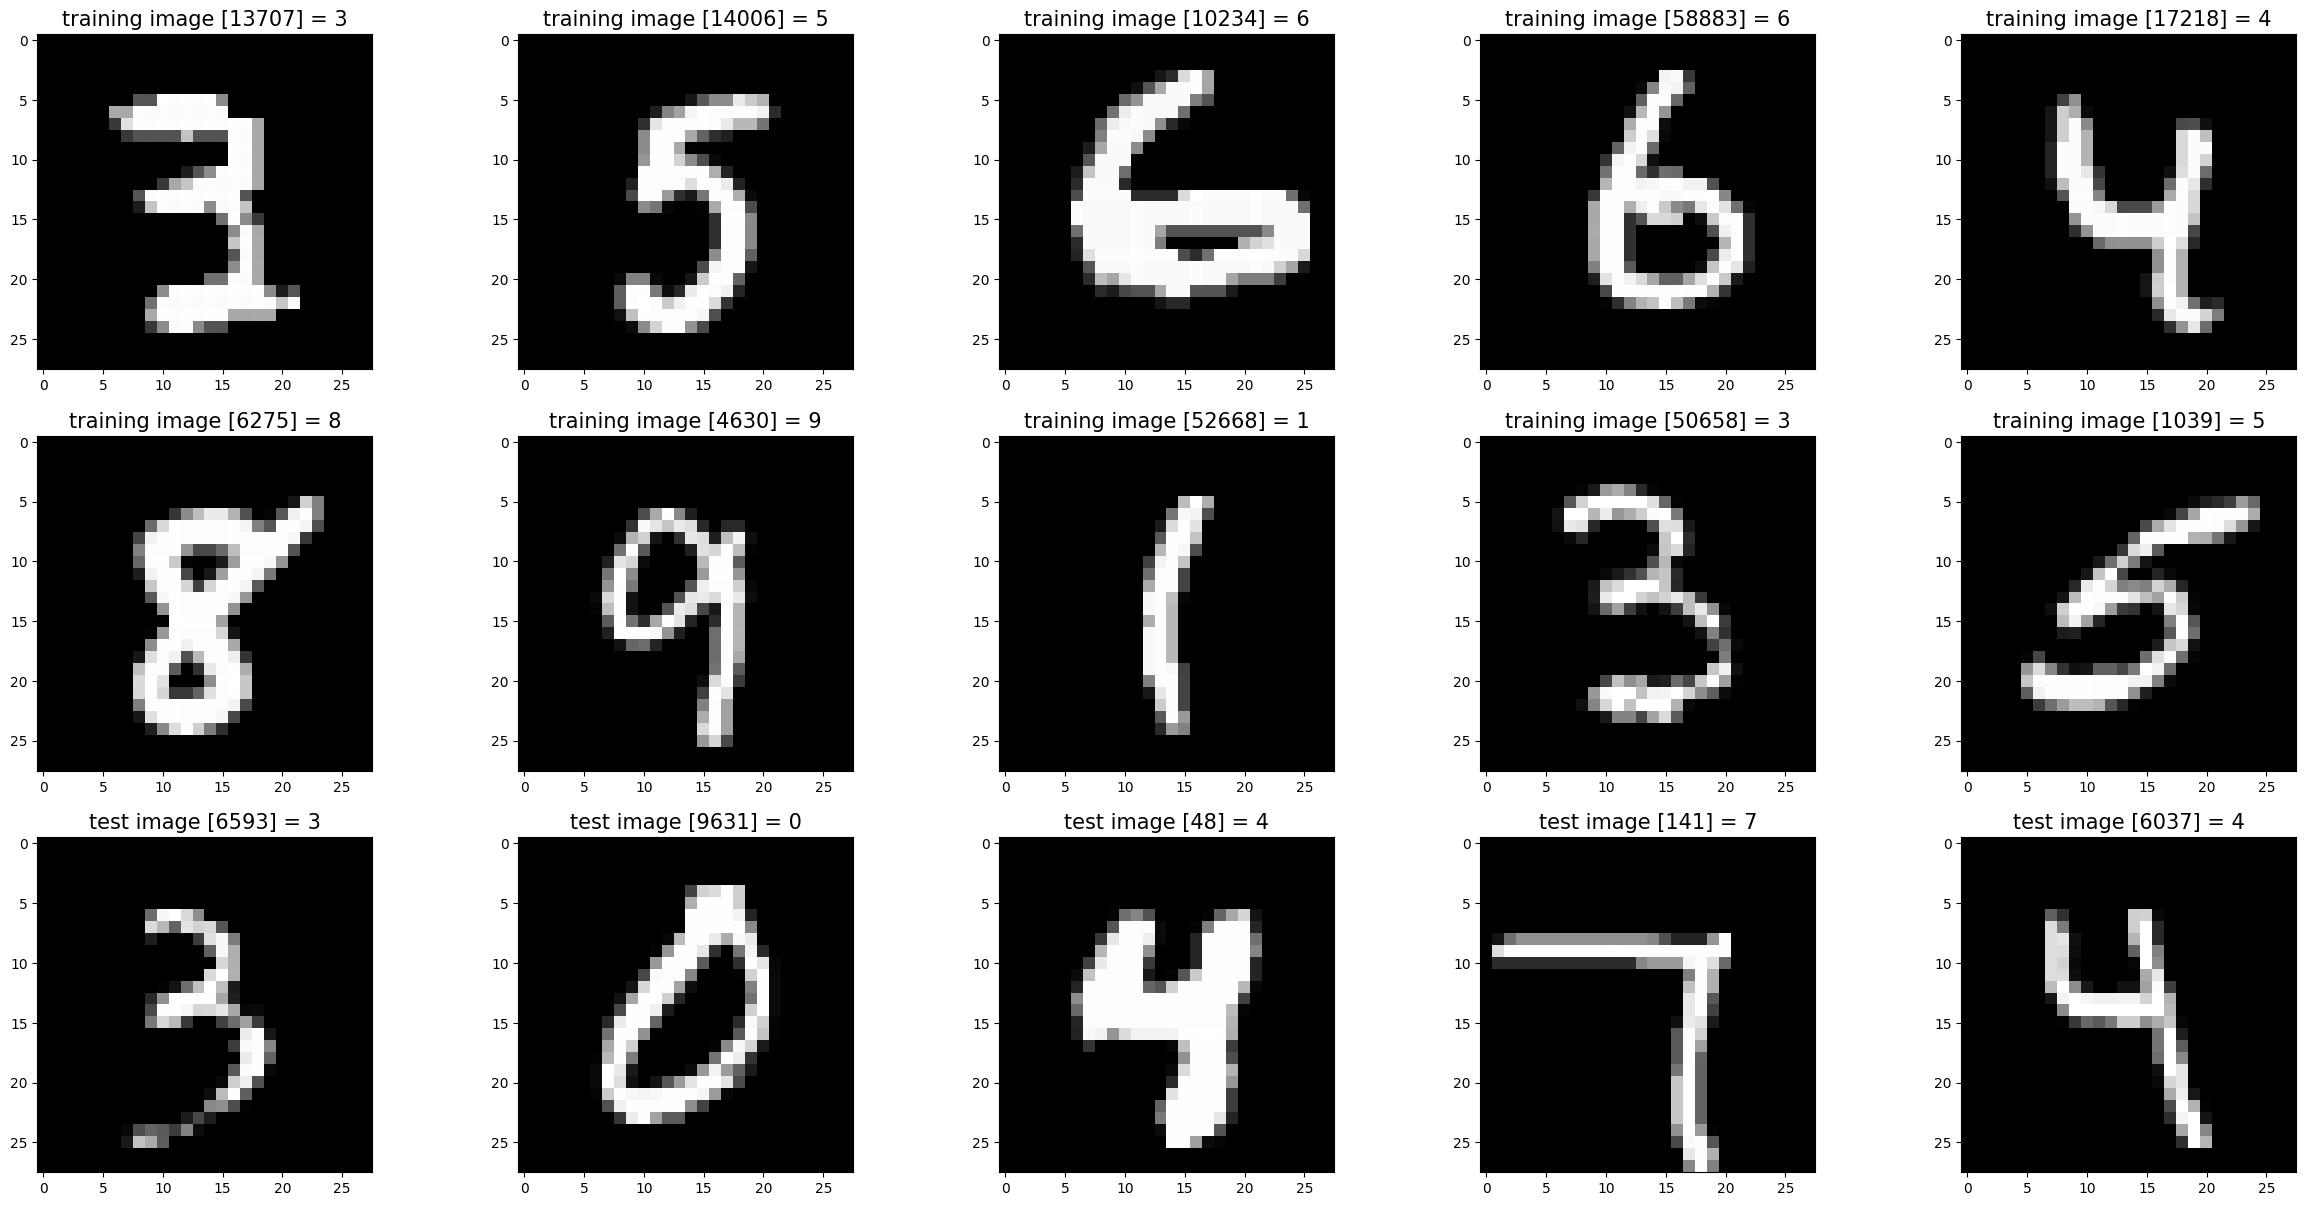

In [6]:
training_images_filepath = 'data/train-images.idx3-ubyte'
training_labels_filepath = 'data/train-labels.idx1-ubyte'
test_images_filepath = 'data/t10k-images.idx3-ubyte'
test_labels_filepath = 'data/t10k-labels.idx1-ubyte'

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

mnist_dataloader = MnistDataloader(training_images_filepath,
                                   training_labels_filepath,
                                   test_images_filepath,
                                   test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

## EDA
The MNIST dataset is well known and is accepted as clean, but for the sake of good practice, I run through a few checks just to make sure everything is in order. First up, I check out class distribution. If any one digit is significantly overrepresented, it may bias models during training. From the plots below, it looks like classes are fairly well distributed. One is slightly overrepresented in training data, but not to the point where I'm worried about it biasing the model towards it. After the plots I have some housekeeping checks to verify the count of training and test images (10,000 and 60,000 respectively) and to make sure that they're all 28x28 greyscale images. Finally, I do one last check just to make sure all of my labels are actually digits 0-9 and there's no sneaky letters or other characters in there. After all checks, it looks like the data is all good so it's time to get things ready for PyTorch.

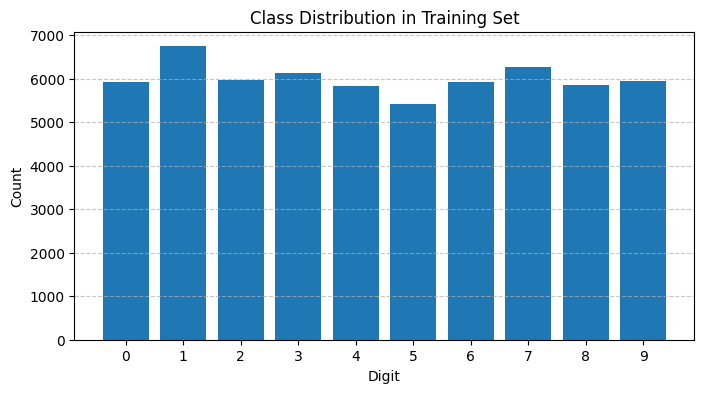

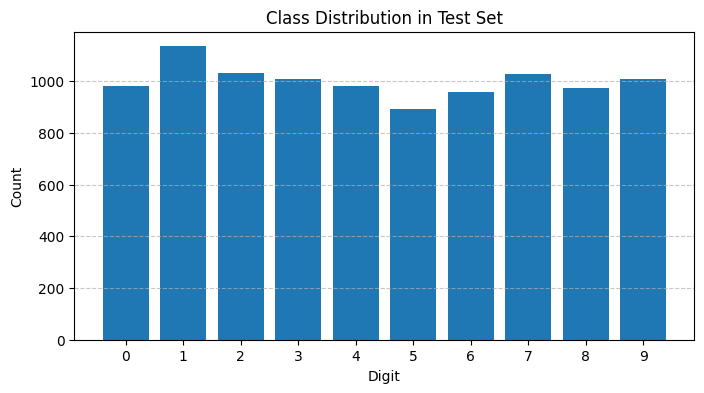

Training Set images shape: (60000, 28, 28)
Training Set dtype: uint8
All Training Set images are 28x28.
Pixel value range in Training Set: 0 to 255

Test Set images shape: (10000, 28, 28)
Test Set dtype: uint8
All Test Set images are 28x28.
Pixel value range in Test Set: 0 to 255

All Training Set labels are valid digits 0–9.
All Test Set labels are valid digits 0–9.


In [7]:
from collections import Counter

def plot_class_distribution(y_data, dataset_name):
    counter = Counter(y_data)
    labels, counts = zip(*sorted(counter.items()))
    
    plt.figure(figsize=(8, 4))
    plt.bar(labels, counts)
    plt.title(f'Class Distribution in {dataset_name}')
    plt.xlabel('Digit')
    plt.ylabel('Count')
    plt.xticks(labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def check_images(images, dataset_name):
    images = np.array(images)  # Convert list to NumPy array if not already
    print(f'{dataset_name} images shape: {images.shape}')
    print(f'{dataset_name} dtype: {images.dtype}')
    
    unique_shapes = {img.shape for img in images}
    if unique_shapes == {(28, 28)}:
        print(f'All {dataset_name} images are 28x28.')
    else:
        print(f'Found images with shapes: {unique_shapes}')
    
    min_pixel = images.min()
    max_pixel = images.max()
    print(f'Pixel value range in {dataset_name}: {min_pixel} to {max_pixel}')
    print()

def check_labels(y_data, dataset_name):
    y_data = np.array(y_data)
    unique_labels = set(y_data)
    
    expected_labels = set(range(10))
    if unique_labels == expected_labels:
        print(f'All {dataset_name} labels are valid digits 0–9.')
    else:
        print(f'{dataset_name} labels contain unexpected values: {unique_labels}')


plot_class_distribution(y_train, 'Training Set')
plot_class_distribution(y_test, 'Test Set')

check_images(x_train, 'Training Set')
check_images(x_test, 'Test Set')

check_labels(y_train, 'Training Set')
check_labels(y_test, 'Test Set')

## Get data tensors ready
Since I'm using PyTorch, I need to get the data ready for use with PyTorch tensors so I can load them onto my GPU. I do this with very standard `Dataset` and `DataLoader` instances.
- Images reshape from `(28, 28)` to `(1, 28, 28)` for CNNs
- Pixel values normalized from `[0-255]` to `[0-1]`
- Labels cast to `torch.long` type for classification loss (will use `CrossEntropyLoss`)

Data loaders:
- Batch size 64 since image data is pretty small
- Train dataset shuffling each epoch is on to avoid order biasing
- Test dataset shuffling is off to keep it ordered for evaluation

In [8]:
from torch.utils.data import Dataset, DataLoader

class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert image to float32 tensor and normalize to [0, 1]
        image = torch.tensor(image, dtype=torch.float32) / 255.0
        
        # Add channel dimension: (28,28) --> (1,28,28)
        image = image.unsqueeze(0)
        
        label = torch.tensor(label, dtype=torch.long)
        
        # Apply additional transform if provided
        if self.transform:
            image = self.transform(image)

        return image, label
    
train_dataset = MNISTDataset(x_train, y_train)
test_dataset = MNISTDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Model building
I'll make three models for this task. My goal is to evaluate performance on this well understood task using a variety of CNN architectures. I'll start very basic with two convolution layers and scale up from there. My deeper model will use four convolution layers and my last model will mimic a VGG (Visual Geometry Group) CNN used for generally much higher performance requiring tasks. With the more complicated CNNs, I expect a bit of overfitting, so I'll need to include some regularization and maybe dropout.

| Feature | Simple CNN | Deeper CNN | Mini-VGG |
|:---|:---|:---|:---|
| # of Conv layers | 2 | 4 | 7 |
| Conv layer structure | 1 Conv ➔ ReLU ➔ Pool ➔ 1 Conv ➔ ReLU ➔ Pool | 2 Conv ➔ ReLU ➔ 2 Conv ➔ ReLU ➔ Pool (repeat) | (2 Conv ➔ Pool) ➔ (2 Conv ➔ Pool) ➔ (3 Conv ➔ Pool) |
| # of Dense layers | 2 (128, 10 units) | 2 (256, 10 units) | 2 (512, 10 units) |
| Expected overfitting | Low | Medium | High (needs dropout) |
| Suitable for | Quick baseline model | Learning deeper feature hierarchies | Practicing real-world deep model patterns |
| Regularization needed? | No (optional) | Maybe (batchnorm helps) | Yes (batchnorm + dropout to avoid overfitting) |


### Simple CNN Model
This will be the simplest CNN model that I train. It will have the following architecture:
- Conv block 1: Conv layer (32 filters, 3x3 kernel) ➔ ReLU ➔ Max Pool (2 stride)
- Conv block 2: Conv layer (64 filters, 3x3 kernel) ➔ ReLU ➔ Max Pool (2 stride)
- Fully connected 1: Dense layer (128 units) ➔ ReLU
- Fully connected 2: Output layer (10 units - one per digit)

In [9]:
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 7x7 is size after two poolings from 28x28
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 ➔ ReLU ➔ Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 ➔ ReLU ➔ Pool
        x = x.view(x.size(0), -1)             # Flatten
        x = F.relu(self.fc1(x))                # FC1 ➔ ReLU
        x = self.fc2(x)                        # FC2 (output layer)
        return x

### Deeper CNN Model
This will be the middle model in terms of complexity that I train. It will have the following architecture:
- Conv Block 1: Conv layer (32 filters, 3x3 kernel) ➔ Conv layer (32 filters, 3x3 kernel) ➔ ReLU ➔ Max Pool (2 stride)
- Conv Block 2: Conv layer (64 filters, 3x3 kernel) ➔ Conv layer (64 filters, 3x3 kernel) ➔ ReLU ➔ Max Pool (2 stride)
- Fully connected 1: Dense layer (256 units) ➔ ReLU
- Fully connected 2:  Output layer (10 units - one per digit)

In [10]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        
        # First conv block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        
        # Second conv block
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 256)  # After two poolings: 28→14→7
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # First conv block
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # Second conv block
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Mini VGG Model
This will be the most complex model I train with hopefully the best performance (at risk of overfitting). It will have the following architecture:
- Conv Block 1: Conv layer (64 filters, 3×3 kernel) ➔ ReLU ➔ Conv layer (64 filters, 3×3 kernel) ➔ ReLU ➔ MaxPool2d(2 stride)
- Conv Block 2: Conv layer (128 filters, 3×3 kernel) ➔ ReLU ➔ Conv layer (128 filters, 3×3 kernel) ➔ ReLU ➔ MaxPool2d(2 stride)
- Conv Block 3: Conv layer (256 filters, 3×3 kernel) ➔ ReLU ➔ Conv layer (256 filters, 3×3 kernel) ➔ ReLU ➔ Conv2d(256 filters, 3×3 kernel) ➔ ReLU ➔ MaxPool2d(2 stride)
- Fully Connected 1	Dense (512 units) ➔ ReLU ➔ Dropout(0.5) to hopefully avoid overfitting
- Fully Connected 2	Dense (10 units- again, one per digit)

I'm adding this after the fact, but I also have batch normalization after every conv layer.


In [11]:
class MiniVGG(nn.Module):
    def __init__(self):
        super(MiniVGG, self).__init__()
        
        # First conv block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Second conv block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Third conv block
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        
        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 3 * 3, 512)  # After three poolings from 28x28
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # First conv block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        # Second conv block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        
        # Third conv block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

## Model training
Now that I've got my models, it's time for the training loop. Because this is a classification task, I'll use `nn.CrossEntropyLoss`. For my optimizer I'll use an Adam optimizer. I'll also use a learning rate scheduler to I'll monitor training progress using tensorboard.

In [12]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

def train_model(model, train_loader, test_loader, 
                num_epochs=10, learning_rate=0.001, device='cuda', 
                scheduler_step_size=5, scheduler_gamma=0.5, 
                log_dir='runs/mnist_experiment'):
    
    # Move model to device (cuda)
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
    
    # Set up TensorBoard writer
    writer = SummaryWriter(log_dir=log_dir)
    
    global_step = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Log training loss every batch
            writer.add_scalar('Loss/train_batch', loss.item(), global_step)
            global_step += 1
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        
        # Evaluation phase
        model.eval()
        running_loss_test = 0.0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_test += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        test_loss = running_loss_test / len(test_loader)
        test_accuracy = 100 * correct_test / total_test
        
        # Step the learning rate scheduler
        scheduler.step()
        
        # TensorBoard logging for epoch summary
        writer.add_scalar('Loss/train_epoch', train_loss, epoch)
        writer.add_scalar('Loss/test_epoch', test_loss, epoch)
        writer.add_scalar('Accuracy/train_epoch', train_accuracy, epoch)
        writer.add_scalar('Accuracy/test_epoch', test_accuracy, epoch)
        writer.add_scalar('Learning_rate', scheduler.get_last_lr()[0], epoch)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {train_loss:.4f} - '
              f'Train Acc: {train_accuracy:.2f}% - '
              f'Test Loss: {test_loss:.4f} - '
              f'Test Acc: {test_accuracy:.2f}% - '
              f'LR: {scheduler.get_last_lr()[0]:.6f}')
    
    # Close TensorBoard writer
    writer.close()
    print('Training complete.')

## Run Training Loop
I check that CUDA is working before running and if it is, I run all of my models on my RTX 3090. After each model is trained, I clear my GPU's VRAM using `toch.cuda.empty_cache()` just to avoid clogging it up.

In [13]:
simpleCNN = SimpleCNN()
deeperCNN = DeeperCNN()
miniVGG = MiniVGG()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    print('Using CPU')

num_epochs = 30

print('Training Simple CNN Model')
train_model(simpleCNN, train_loader, test_loader,
            num_epochs=num_epochs, 
            learning_rate=0.001,
            device=device,
            scheduler_step_size=5,  # Decrease LR every 5 epochs
            scheduler_gamma=0.5,    # Halve the LR each step
            log_dir='runs/simplecnn_mnist')

torch.cuda.empty_cache()

print('Training Deeper CNN Model')
train_model(deeperCNN, train_loader, test_loader,
            num_epochs=num_epochs, 
            learning_rate=0.001,
            device=device,
            scheduler_step_size=5,  # Decrease LR every 5 epochs
            scheduler_gamma=0.5,    # Halve the LR each step
            log_dir='runs/deepercnn_mnist')

torch.cuda.empty_cache()

print('Training Mini-VGG Model')

train_model(miniVGG, train_loader, test_loader,
            num_epochs=num_epochs, 
            learning_rate=0.001,
            device=device,
            scheduler_step_size=5,  # Decrease LR every 5 epochs
            scheduler_gamma=0.5,    # Halve the LR each step
            log_dir='runs/minivgg_mnist')

Using GPU: NVIDIA GeForce RTX 3090
Training Simple CNN Model


  0%|          | 0/938 [00:00<?, ?it/s]C:\Users\rahul\AppData\Local\Temp\ipykernel_35928\3777957037.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  image = torch.tensor(image, dtype=torch.float32) / 255.0
100%|██████████| 938/938 [00:06<00:00, 145.62it/s]


Epoch [1/30] - Train Loss: 0.2089 - Train Acc: 93.52% - Test Loss: 0.0668 - Test Acc: 97.81% - LR: 0.001000


100%|██████████| 938/938 [00:06<00:00, 143.04it/s]


Epoch [2/30] - Train Loss: 0.0558 - Train Acc: 98.32% - Test Loss: 0.0390 - Test Acc: 98.78% - LR: 0.001000


100%|██████████| 938/938 [00:07<00:00, 131.17it/s]


Epoch [3/30] - Train Loss: 0.0385 - Train Acc: 98.78% - Test Loss: 0.0338 - Test Acc: 98.83% - LR: 0.001000


100%|██████████| 938/938 [00:07<00:00, 132.71it/s]


Epoch [4/30] - Train Loss: 0.0298 - Train Acc: 99.03% - Test Loss: 0.0393 - Test Acc: 98.61% - LR: 0.001000


100%|██████████| 938/938 [00:06<00:00, 140.09it/s]


Epoch [5/30] - Train Loss: 0.0228 - Train Acc: 99.26% - Test Loss: 0.0353 - Test Acc: 98.87% - LR: 0.000500


100%|██████████| 938/938 [00:07<00:00, 133.07it/s]


Epoch [6/30] - Train Loss: 0.0125 - Train Acc: 99.61% - Test Loss: 0.0225 - Test Acc: 99.19% - LR: 0.000500


100%|██████████| 938/938 [00:07<00:00, 125.89it/s]


Epoch [7/30] - Train Loss: 0.0097 - Train Acc: 99.69% - Test Loss: 0.0244 - Test Acc: 99.20% - LR: 0.000500


100%|██████████| 938/938 [00:07<00:00, 127.12it/s]


Epoch [8/30] - Train Loss: 0.0077 - Train Acc: 99.78% - Test Loss: 0.0311 - Test Acc: 99.01% - LR: 0.000500


100%|██████████| 938/938 [00:07<00:00, 127.22it/s]


Epoch [9/30] - Train Loss: 0.0072 - Train Acc: 99.80% - Test Loss: 0.0384 - Test Acc: 98.88% - LR: 0.000500


100%|██████████| 938/938 [00:07<00:00, 126.36it/s]


Epoch [10/30] - Train Loss: 0.0053 - Train Acc: 99.83% - Test Loss: 0.0286 - Test Acc: 99.20% - LR: 0.000250


100%|██████████| 938/938 [00:07<00:00, 129.90it/s]


Epoch [11/30] - Train Loss: 0.0023 - Train Acc: 99.94% - Test Loss: 0.0251 - Test Acc: 99.27% - LR: 0.000250


100%|██████████| 938/938 [00:07<00:00, 127.94it/s]


Epoch [12/30] - Train Loss: 0.0013 - Train Acc: 99.97% - Test Loss: 0.0280 - Test Acc: 99.27% - LR: 0.000250


100%|██████████| 938/938 [00:07<00:00, 133.73it/s]


Epoch [13/30] - Train Loss: 0.0009 - Train Acc: 99.99% - Test Loss: 0.0294 - Test Acc: 99.27% - LR: 0.000250


100%|██████████| 938/938 [00:06<00:00, 135.83it/s]


Epoch [14/30] - Train Loss: 0.0014 - Train Acc: 99.96% - Test Loss: 0.0392 - Test Acc: 99.13% - LR: 0.000250


100%|██████████| 938/938 [00:07<00:00, 132.54it/s]


Epoch [15/30] - Train Loss: 0.0007 - Train Acc: 99.98% - Test Loss: 0.0310 - Test Acc: 99.26% - LR: 0.000125


100%|██████████| 938/938 [00:06<00:00, 138.20it/s]


Epoch [16/30] - Train Loss: 0.0003 - Train Acc: 100.00% - Test Loss: 0.0308 - Test Acc: 99.26% - LR: 0.000125


100%|██████████| 938/938 [00:07<00:00, 133.32it/s]


Epoch [17/30] - Train Loss: 0.0002 - Train Acc: 100.00% - Test Loss: 0.0320 - Test Acc: 99.29% - LR: 0.000125


100%|██████████| 938/938 [00:06<00:00, 144.53it/s]


Epoch [18/30] - Train Loss: 0.0001 - Train Acc: 100.00% - Test Loss: 0.0328 - Test Acc: 99.24% - LR: 0.000125


100%|██████████| 938/938 [00:07<00:00, 132.27it/s]


Epoch [19/30] - Train Loss: 0.0002 - Train Acc: 100.00% - Test Loss: 0.0344 - Test Acc: 99.25% - LR: 0.000125


100%|██████████| 938/938 [00:06<00:00, 138.57it/s]


Epoch [20/30] - Train Loss: 0.0002 - Train Acc: 100.00% - Test Loss: 0.0352 - Test Acc: 99.22% - LR: 0.000063


100%|██████████| 938/938 [00:07<00:00, 133.57it/s]


Epoch [21/30] - Train Loss: 0.0001 - Train Acc: 100.00% - Test Loss: 0.0356 - Test Acc: 99.26% - LR: 0.000063


100%|██████████| 938/938 [00:06<00:00, 140.13it/s]


Epoch [22/30] - Train Loss: 0.0001 - Train Acc: 100.00% - Test Loss: 0.0354 - Test Acc: 99.28% - LR: 0.000063


100%|██████████| 938/938 [00:07<00:00, 123.24it/s]


Epoch [23/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0373 - Test Acc: 99.27% - LR: 0.000063


100%|██████████| 938/938 [00:07<00:00, 131.17it/s]


Epoch [24/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0373 - Test Acc: 99.29% - LR: 0.000063


100%|██████████| 938/938 [00:06<00:00, 144.82it/s]


Epoch [25/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0373 - Test Acc: 99.25% - LR: 0.000031


100%|██████████| 938/938 [00:06<00:00, 139.42it/s]


Epoch [26/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0380 - Test Acc: 99.27% - LR: 0.000031


100%|██████████| 938/938 [00:06<00:00, 141.96it/s]


Epoch [27/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0396 - Test Acc: 99.29% - LR: 0.000031


100%|██████████| 938/938 [00:06<00:00, 139.95it/s]


Epoch [28/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0394 - Test Acc: 99.29% - LR: 0.000031


100%|██████████| 938/938 [00:06<00:00, 140.75it/s]


Epoch [29/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0400 - Test Acc: 99.26% - LR: 0.000031


100%|██████████| 938/938 [00:06<00:00, 141.02it/s]


Epoch [30/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0412 - Test Acc: 99.31% - LR: 0.000016
Training complete.
Training Deeper CNN Model


100%|██████████| 938/938 [00:07<00:00, 128.06it/s]


Epoch [1/30] - Train Loss: 0.1510 - Train Acc: 95.30% - Test Loss: 0.0427 - Test Acc: 98.63% - LR: 0.001000


100%|██████████| 938/938 [00:07<00:00, 127.99it/s]


Epoch [2/30] - Train Loss: 0.0412 - Train Acc: 98.71% - Test Loss: 0.0315 - Test Acc: 98.96% - LR: 0.001000


100%|██████████| 938/938 [00:07<00:00, 131.48it/s]


Epoch [3/30] - Train Loss: 0.0285 - Train Acc: 99.13% - Test Loss: 0.0259 - Test Acc: 99.21% - LR: 0.001000


100%|██████████| 938/938 [00:07<00:00, 128.90it/s]


Epoch [4/30] - Train Loss: 0.0215 - Train Acc: 99.33% - Test Loss: 0.0237 - Test Acc: 99.20% - LR: 0.001000


100%|██████████| 938/938 [00:07<00:00, 128.48it/s]


Epoch [5/30] - Train Loss: 0.0154 - Train Acc: 99.52% - Test Loss: 0.0238 - Test Acc: 99.30% - LR: 0.000500


100%|██████████| 938/938 [00:07<00:00, 126.99it/s]


Epoch [6/30] - Train Loss: 0.0064 - Train Acc: 99.80% - Test Loss: 0.0297 - Test Acc: 99.24% - LR: 0.000500


100%|██████████| 938/938 [00:07<00:00, 128.62it/s]


Epoch [7/30] - Train Loss: 0.0038 - Train Acc: 99.88% - Test Loss: 0.0307 - Test Acc: 99.16% - LR: 0.000500


100%|██████████| 938/938 [00:07<00:00, 129.17it/s]


Epoch [8/30] - Train Loss: 0.0043 - Train Acc: 99.85% - Test Loss: 0.0292 - Test Acc: 99.26% - LR: 0.000500


100%|██████████| 938/938 [00:07<00:00, 131.10it/s]


Epoch [9/30] - Train Loss: 0.0036 - Train Acc: 99.89% - Test Loss: 0.0226 - Test Acc: 99.37% - LR: 0.000500


100%|██████████| 938/938 [00:07<00:00, 131.19it/s]


Epoch [10/30] - Train Loss: 0.0030 - Train Acc: 99.90% - Test Loss: 0.0331 - Test Acc: 99.17% - LR: 0.000250


100%|██████████| 938/938 [00:07<00:00, 130.14it/s]


Epoch [11/30] - Train Loss: 0.0009 - Train Acc: 99.97% - Test Loss: 0.0275 - Test Acc: 99.39% - LR: 0.000250


100%|██████████| 938/938 [00:07<00:00, 129.57it/s]


Epoch [12/30] - Train Loss: 0.0001 - Train Acc: 100.00% - Test Loss: 0.0315 - Test Acc: 99.33% - LR: 0.000250


100%|██████████| 938/938 [00:07<00:00, 128.71it/s]


Epoch [13/30] - Train Loss: 0.0001 - Train Acc: 100.00% - Test Loss: 0.0314 - Test Acc: 99.40% - LR: 0.000250


100%|██████████| 938/938 [00:07<00:00, 129.00it/s]


Epoch [14/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0326 - Test Acc: 99.36% - LR: 0.000250


100%|██████████| 938/938 [00:07<00:00, 128.73it/s]


Epoch [15/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0343 - Test Acc: 99.38% - LR: 0.000125


100%|██████████| 938/938 [00:07<00:00, 129.96it/s]


Epoch [16/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0350 - Test Acc: 99.38% - LR: 0.000125


100%|██████████| 938/938 [00:07<00:00, 128.69it/s]


Epoch [17/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0363 - Test Acc: 99.38% - LR: 0.000125


100%|██████████| 938/938 [00:07<00:00, 131.49it/s]


Epoch [18/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0374 - Test Acc: 99.40% - LR: 0.000125


100%|██████████| 938/938 [00:07<00:00, 133.00it/s]


Epoch [19/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0387 - Test Acc: 99.39% - LR: 0.000125


100%|██████████| 938/938 [00:07<00:00, 132.20it/s]


Epoch [20/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0406 - Test Acc: 99.39% - LR: 0.000063


100%|██████████| 938/938 [00:07<00:00, 131.69it/s]


Epoch [21/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0415 - Test Acc: 99.39% - LR: 0.000063


100%|██████████| 938/938 [00:07<00:00, 131.22it/s]


Epoch [22/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0426 - Test Acc: 99.39% - LR: 0.000063


100%|██████████| 938/938 [00:07<00:00, 129.80it/s]


Epoch [23/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0439 - Test Acc: 99.37% - LR: 0.000063


100%|██████████| 938/938 [00:07<00:00, 129.34it/s]


Epoch [24/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0457 - Test Acc: 99.38% - LR: 0.000063


100%|██████████| 938/938 [00:07<00:00, 126.29it/s]


Epoch [25/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0474 - Test Acc: 99.38% - LR: 0.000031


100%|██████████| 938/938 [00:07<00:00, 130.87it/s]


Epoch [26/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0481 - Test Acc: 99.38% - LR: 0.000031


100%|██████████| 938/938 [00:07<00:00, 127.57it/s]


Epoch [27/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0491 - Test Acc: 99.38% - LR: 0.000031


100%|██████████| 938/938 [00:06<00:00, 150.56it/s]


Epoch [28/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0503 - Test Acc: 99.38% - LR: 0.000031


100%|██████████| 938/938 [00:06<00:00, 151.21it/s]


Epoch [29/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0523 - Test Acc: 99.38% - LR: 0.000031


100%|██████████| 938/938 [00:06<00:00, 149.50it/s]


Epoch [30/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0536 - Test Acc: 99.38% - LR: 0.000016
Training complete.
Training Mini-VGG Model


100%|██████████| 938/938 [00:09<00:00, 99.88it/s] 


Epoch [1/30] - Train Loss: 0.1310 - Train Acc: 96.13% - Test Loss: 0.1181 - Test Acc: 96.53% - LR: 0.001000


100%|██████████| 938/938 [00:09<00:00, 101.46it/s]


Epoch [2/30] - Train Loss: 0.0496 - Train Acc: 98.56% - Test Loss: 0.0208 - Test Acc: 99.38% - LR: 0.001000


100%|██████████| 938/938 [00:09<00:00, 101.46it/s]


Epoch [3/30] - Train Loss: 0.0391 - Train Acc: 98.91% - Test Loss: 0.0234 - Test Acc: 99.35% - LR: 0.001000


100%|██████████| 938/938 [00:09<00:00, 101.11it/s]


Epoch [4/30] - Train Loss: 0.0313 - Train Acc: 99.06% - Test Loss: 0.0249 - Test Acc: 99.31% - LR: 0.001000


100%|██████████| 938/938 [00:09<00:00, 101.62it/s]


Epoch [5/30] - Train Loss: 0.0278 - Train Acc: 99.25% - Test Loss: 0.0199 - Test Acc: 99.34% - LR: 0.000500


100%|██████████| 938/938 [00:09<00:00, 101.42it/s]


Epoch [6/30] - Train Loss: 0.0138 - Train Acc: 99.57% - Test Loss: 0.0177 - Test Acc: 99.51% - LR: 0.000500


100%|██████████| 938/938 [00:09<00:00, 101.42it/s]


Epoch [7/30] - Train Loss: 0.0104 - Train Acc: 99.70% - Test Loss: 0.0167 - Test Acc: 99.53% - LR: 0.000500


100%|██████████| 938/938 [00:09<00:00, 100.30it/s]


Epoch [8/30] - Train Loss: 0.0102 - Train Acc: 99.72% - Test Loss: 0.0207 - Test Acc: 99.49% - LR: 0.000500


100%|██████████| 938/938 [00:10<00:00, 87.86it/s]


Epoch [9/30] - Train Loss: 0.0107 - Train Acc: 99.68% - Test Loss: 0.0253 - Test Acc: 99.38% - LR: 0.000500


100%|██████████| 938/938 [00:10<00:00, 89.20it/s]


Epoch [10/30] - Train Loss: 0.0079 - Train Acc: 99.77% - Test Loss: 0.0238 - Test Acc: 99.38% - LR: 0.000250


100%|██████████| 938/938 [00:10<00:00, 87.91it/s]


Epoch [11/30] - Train Loss: 0.0039 - Train Acc: 99.89% - Test Loss: 0.0259 - Test Acc: 99.39% - LR: 0.000250


100%|██████████| 938/938 [00:10<00:00, 91.38it/s]


Epoch [12/30] - Train Loss: 0.0022 - Train Acc: 99.94% - Test Loss: 0.0202 - Test Acc: 99.57% - LR: 0.000250


100%|██████████| 938/938 [00:10<00:00, 92.07it/s]


Epoch [13/30] - Train Loss: 0.0028 - Train Acc: 99.92% - Test Loss: 0.0207 - Test Acc: 99.58% - LR: 0.000250


100%|██████████| 938/938 [00:10<00:00, 91.62it/s]


Epoch [14/30] - Train Loss: 0.0022 - Train Acc: 99.93% - Test Loss: 0.0231 - Test Acc: 99.60% - LR: 0.000250


100%|██████████| 938/938 [00:10<00:00, 91.70it/s]


Epoch [15/30] - Train Loss: 0.0019 - Train Acc: 99.94% - Test Loss: 0.0394 - Test Acc: 99.27% - LR: 0.000125


100%|██████████| 938/938 [00:10<00:00, 91.18it/s]


Epoch [16/30] - Train Loss: 0.0013 - Train Acc: 99.96% - Test Loss: 0.0242 - Test Acc: 99.61% - LR: 0.000125


100%|██████████| 938/938 [00:10<00:00, 89.05it/s]


Epoch [17/30] - Train Loss: 0.0007 - Train Acc: 99.99% - Test Loss: 0.0220 - Test Acc: 99.61% - LR: 0.000125


100%|██████████| 938/938 [00:10<00:00, 89.48it/s]


Epoch [18/30] - Train Loss: 0.0006 - Train Acc: 99.98% - Test Loss: 0.0332 - Test Acc: 99.45% - LR: 0.000125


100%|██████████| 938/938 [00:10<00:00, 90.13it/s]


Epoch [19/30] - Train Loss: 0.0003 - Train Acc: 99.99% - Test Loss: 0.0273 - Test Acc: 99.62% - LR: 0.000125


100%|██████████| 938/938 [00:10<00:00, 91.33it/s]


Epoch [20/30] - Train Loss: 0.0009 - Train Acc: 99.97% - Test Loss: 0.0236 - Test Acc: 99.62% - LR: 0.000063


100%|██████████| 938/938 [00:10<00:00, 90.72it/s]


Epoch [21/30] - Train Loss: 0.0003 - Train Acc: 99.99% - Test Loss: 0.0260 - Test Acc: 99.58% - LR: 0.000063


100%|██████████| 938/938 [00:10<00:00, 91.26it/s]


Epoch [22/30] - Train Loss: 0.0001 - Train Acc: 100.00% - Test Loss: 0.0266 - Test Acc: 99.58% - LR: 0.000063


100%|██████████| 938/938 [00:10<00:00, 91.46it/s]


Epoch [23/30] - Train Loss: 0.0001 - Train Acc: 100.00% - Test Loss: 0.0272 - Test Acc: 99.60% - LR: 0.000063


100%|██████████| 938/938 [00:10<00:00, 93.02it/s]


Epoch [24/30] - Train Loss: 0.0001 - Train Acc: 100.00% - Test Loss: 0.0271 - Test Acc: 99.59% - LR: 0.000063


100%|██████████| 938/938 [00:10<00:00, 92.07it/s]


Epoch [25/30] - Train Loss: 0.0002 - Train Acc: 100.00% - Test Loss: 0.0272 - Test Acc: 99.58% - LR: 0.000031


100%|██████████| 938/938 [00:10<00:00, 89.38it/s]


Epoch [26/30] - Train Loss: 0.0001 - Train Acc: 100.00% - Test Loss: 0.0270 - Test Acc: 99.59% - LR: 0.000031


100%|██████████| 938/938 [00:10<00:00, 88.26it/s]


Epoch [27/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0279 - Test Acc: 99.58% - LR: 0.000031


100%|██████████| 938/938 [00:10<00:00, 87.87it/s]


Epoch [28/30] - Train Loss: 0.0001 - Train Acc: 100.00% - Test Loss: 0.0288 - Test Acc: 99.59% - LR: 0.000031


100%|██████████| 938/938 [00:10<00:00, 88.80it/s]


Epoch [29/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0291 - Test Acc: 99.58% - LR: 0.000031


100%|██████████| 938/938 [00:10<00:00, 88.76it/s]


Epoch [30/30] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0310 - Test Acc: 99.60% - LR: 0.000016
Training complete.


## Training Evaluation
The below code block grabs the tracked training stats from my `tensorboard` logs and plots them in a set of subplots. There's a few observations we can make from these:
- Train Loss:
    - All models drop their training loss very rapidly in the first 5–7 epochs. After about epoch 10, all models have nearly zero train loss which means the models likely didn't develop usefully for the full duration of the 30 epochs I used. It actually looks like the medium CNN `DeeperCNN` converged the fastest. If I had to guess, the only reason `MiniVGG` didn't win was because of the dropout and batch normalization. If anything, letting the models train past convergence would only really cause overfitting.
- Test Loss:
    - As the models converge, test loss decreases nicely across models. Around epochs 5-10, the models all reach their minimum loss and then gradually increase. This actually indicates that there may be some overfitting going on. Overall, the most complex model MiniVGG had the lowest overall test loss which may be due to measures taken to combat overfitting (dropout/batch normalization).
- Train Accuracy:
    - As reflected in the training loss stats, the models all converge to 100% train accuracy around epoch 10. This means the models fully "learned" the dataset.
- Test Accuracy:
    - Again, all models have a sharp increase in test accuracy initially and gradually climb until after epoch 10 at which point test accuracy is more or less flat with some minor variation. As expected, the `SimpleCNN` model performed worst with `MiniVGG` performing best and `DeeperCNN` in the middle.

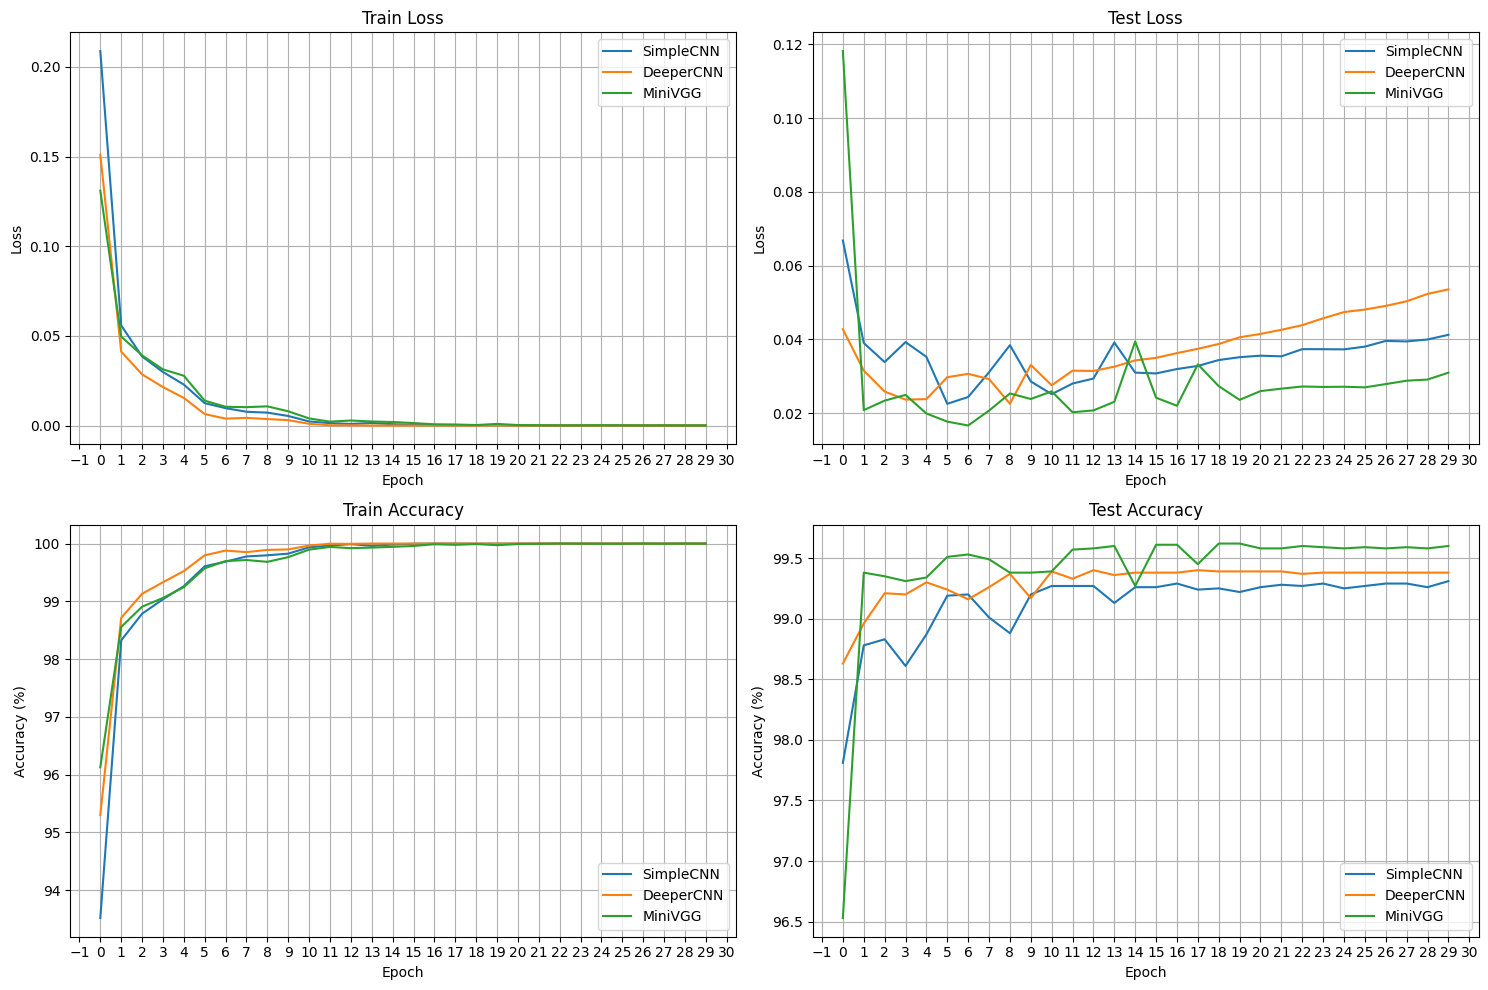

In [14]:
from tensorboard.backend.event_processing import event_accumulator
from matplotlib.ticker import MultipleLocator

# Helper function to load event data
def load_scalars(log_dir, tag):
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()
    scalars = ea.Scalars(tag)
    steps = [s.step for s in scalars]
    values = [s.value for s in scalars]
    return steps, values


log_dirs = {
    'SimpleCNN': 'runs/simplecnn_mnist',
    'DeeperCNN': 'runs/deepercnn_mnist',
    'MiniVGG': 'runs/minivgg_mnist'
}

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot Loss (Train)
for model_name, log_dir in log_dirs.items():
    steps, values = load_scalars(log_dir, 'Loss/train_epoch')
    axes[0, 0].plot(steps, values, label=model_name)
axes[0, 0].set_title('Train Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].xaxis.set_major_locator(MultipleLocator(1))

# Plot Loss (Test)
for model_name, log_dir in log_dirs.items():
    steps, values = load_scalars(log_dir, 'Loss/test_epoch')
    axes[0, 1].plot(steps, values, label=model_name)
axes[0, 1].set_title('Test Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[0, 1].xaxis.set_major_locator(MultipleLocator(1))

# Plot Accuracy (Train)
for model_name, log_dir in log_dirs.items():
    steps, values = load_scalars(log_dir, 'Accuracy/train_epoch')
    axes[1, 0].plot(steps, values, label=model_name)
axes[1, 0].set_title('Train Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].legend()
axes[1, 0].grid(True)
axes[1, 0].xaxis.set_major_locator(MultipleLocator(1))

# Plot Accuracy (Test)
for model_name, log_dir in log_dirs.items():
    steps, values = load_scalars(log_dir, 'Accuracy/test_epoch')
    axes[1, 1].plot(steps, values, label=model_name)
axes[1, 1].set_title('Test Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].legend()
axes[1, 1].grid(True)
axes[1, 1].xaxis.set_major_locator(MultipleLocator(1))

plt.tight_layout()
plt.show()

## Final Model Performances
As I mentioned, in the previous section, the `SimpleCNN` model performed worst with `MiniVGG` performing best and `DeeperCNN` in the middle. Of the 10,000 test images, the simple model and medium model actually performed pretty similarly at 69 and 62 misses respectively. The Mini-VGG model performed the best by a good bit with only 40 misses.

In [15]:
def evaluate_model(model, test_loader, device='cpu'):
    model = model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    
    misclassified = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Find misclassified indices
            mismatch = predicted != labels
            for img, true_label, pred_label in zip(inputs[mismatch], labels[mismatch], predicted[mismatch]):
                    misclassified.append((img.cpu(), true_label.cpu(), pred_label.cpu()))

    accuracy = 100 * correct / total
    
    return accuracy, misclassified

models = {
    'SimpleCNN': simpleCNN,
    'DeeperCNN': deeperCNN,
    'Mini-VGG': miniVGG
}

print('Final Evaluation Report:\n')

final_results = {}

for model_name, model in models.items():
    accuracy, misclassified = evaluate_model(model, test_loader, device=device)

    final_results[model_name] = {
         'accuracy': accuracy,
         'misclassified': misclassified
    }

    print(f'{model_name}:')
    print(f'  Test Accuracy: {accuracy:.2f}%')
    print(f'  Misclassified Samples: {len(misclassified)}\n')


Final Evaluation Report:

SimpleCNN:
  Test Accuracy: 99.31%
  Misclassified Samples: 69

DeeperCNN:
  Test Accuracy: 99.38%
  Misclassified Samples: 62

Mini-VGG:
  Test Accuracy: 99.60%
  Misclassified Samples: 40



## Digging into Model Performance
Now that I've got all of my performances nicely calculated, it will be interesting to see what the models actually struggled with and what went well. Both the simple and medium models actually struggled with the same digits. They both misclassified seven 5's as 3's. They also both struggled with classifying 9's and predicting 7's as 2's. The complex Mini-VGG model struggled with some different pairings. It didn't miss more than four of any digit-prediction pairing. It seems to conflate the rounder parts of digits 6's as 0's.

Below the confusion matrices I visualize some sample misses. To be honest, for a few of those inputs, I don't know if my human eyes would classify them correctly. Especially those 9's that have incomplete loops. They look a lot like 4's even to me. Some of the 7's written with crosses relatively close to the bottom also look a lot like 2's.

Overall, I think I'm pretty happy with performance as there aren't any obvious examples of overfitting that I am able to observe.

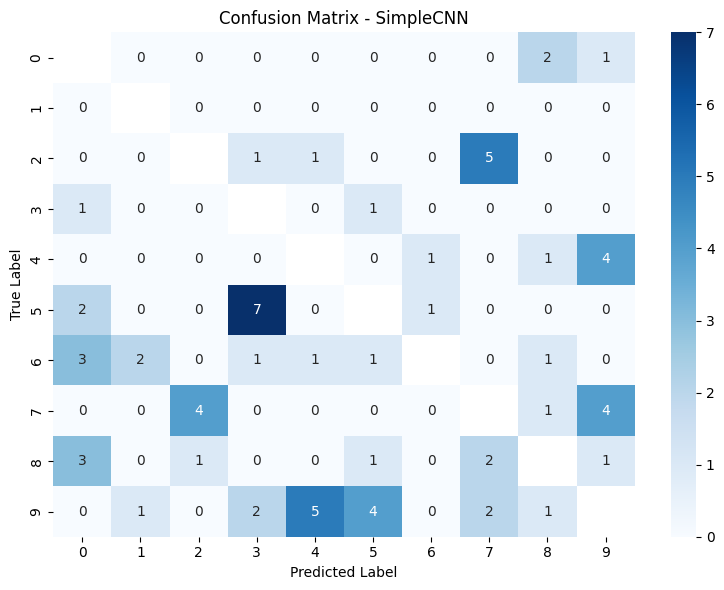

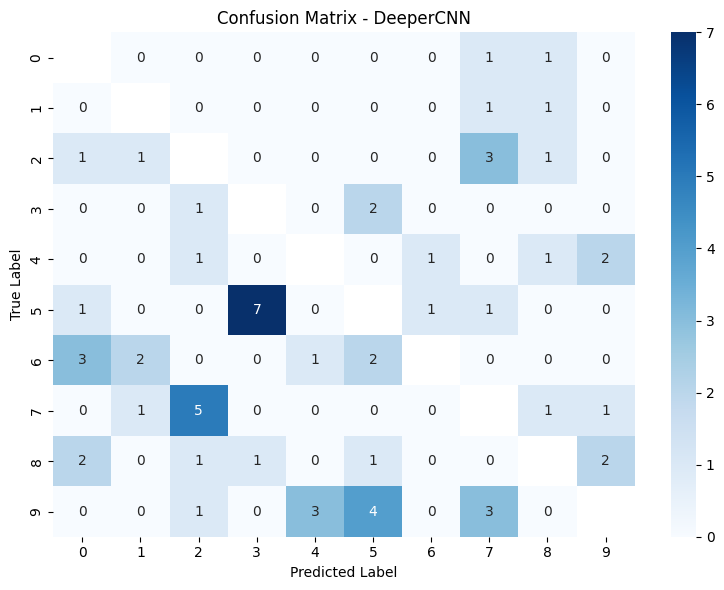

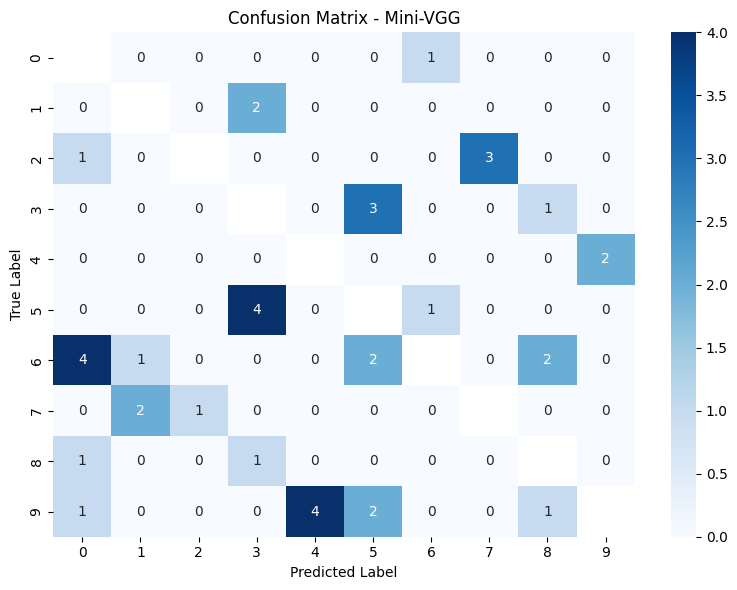


SimpleCNN Misclassified Samples:
True Labels:       6   6   9   7   6   9   4   9
Predicted Labels:  5   0   4   2   8   4   9   3


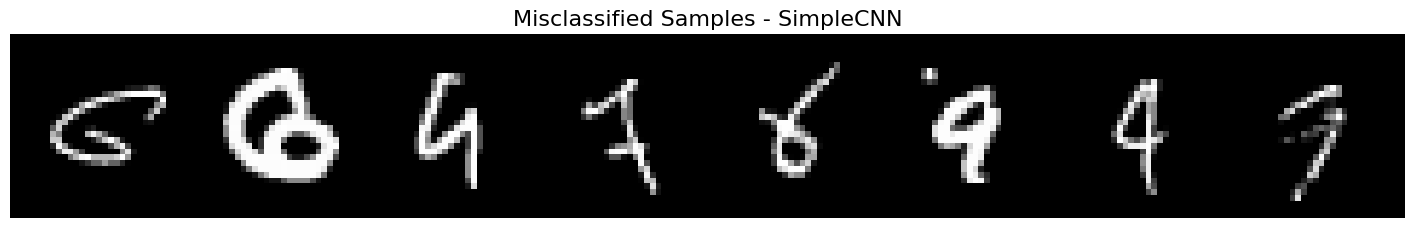


DeeperCNN Misclassified Samples:
True Labels:       4   5   7   9   7   5   9   4
Predicted Labels:  2   3   2   7   9   7   4   9


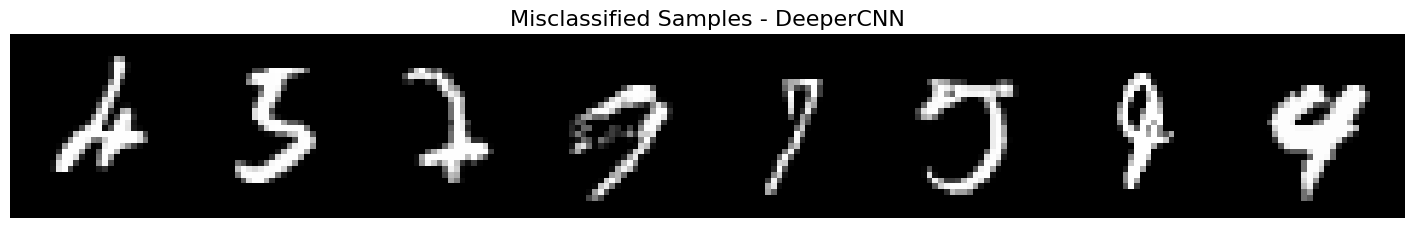


Mini-VGG Misclassified Samples:
True Labels:       3   9   6   4   9   9   5   2
Predicted Labels:  5   0   5   9   4   4   6   0


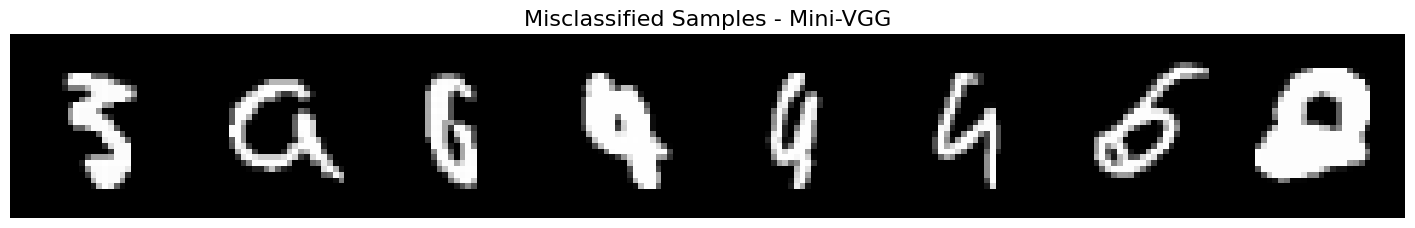

In [22]:
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix
import seaborn as sns

def compute_confusion_matrix(model, test_loader, device='cpu'):
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return confusion_matrix(all_labels, all_preds)

def plot_confusion_matrix(cm, model_name, normalize=False):
    cm = cm.astype('float')
    if normalize:
        cm = cm / cm.sum(axis=1, keepdims=True)
    
    plot_matrix = cm.copy()
    np.fill_diagonal(plot_matrix, np.nan) # Ignore diagonals to highlight misses

    plt.figure(figsize=(8, 6))
    sns.heatmap(plot_matrix,
                annot=True,
                fmt=".4f" if normalize else ".0f",
                cmap='Blues', 
                xticklabels=list(range(10)),
                yticklabels=list(range(10)))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

def show_random_misclassified(final_results, n_samples=8):
    for model_name, result in final_results.items():
        misses = result['misclassified']
        if len(misses) < n_samples:
            print(f"{model_name} has only {len(misses)} misclassified samples.")
            samples = misses
        else:
            samples = random.sample(misses, n_samples)

        # Extract image tensors, predicted and true labels
        images = [img for img, true, pred in samples]
        true_labels = [true.item() for img, true, pred in samples]
        pred_labels = [pred.item() for img, true, pred in samples]

        # Create grid (1 channel grayscale → replicate to 3 for visibility)
        images_rgb = [img.repeat(3, 1, 1) for img in images]  # shape (3, 28, 28)
        grid = make_grid(images_rgb, nrow=n_samples, padding=2)

        # Plot
        plt.figure(figsize=(18, 3))
        plt.imshow(grid.permute(1, 2, 0))  # (C, H, W) → (H, W, C)
        plt.axis('off')
        plt.title(f'Misclassified Samples - {model_name}', fontsize=16)

        # Show per-image annotations
        print(f"\n{model_name} Misclassified Samples:")
        print("True Labels:     ", '  '.join(f"{label:2d}" for label in true_labels))
        print("Predicted Labels:", '  '.join(f"{label:2d}" for label in pred_labels))

        plt.show()

for name, model in models.items():
    cm = compute_confusion_matrix(model, test_loader, device=device)
    plot_confusion_matrix(cm, name, normalize=False)

show_random_misclassified(final_results, n_samples=8)

## Overview/Wrap-up and Final Thoughts
In this project, I set out to build and compare several CNN architectures for handwritten digit classification using the MNIST dataset. I decoded the raw IDX-format MNIST files into usable image and label arrays and performed EDA to validate the class distributions, image shapes, and label correctness across the train and test datasets. This exploration confirmed that MNIST was well-balanced across digits 0–9 and that all images were 28×28 grayscale (MNIST is a well known to be a clean dataset, so this was more best practice than a true exploration).

I designed and trained three progressively deeper CNN models:
- `SimpleCNN`: 2 convolution layers
- `DeeperCNN`: 4 convolution layers
- `MiniVGG`: 7 convolution layers + batch normalization + dropout

Each model was trained using a modular, reusable training loop with dynamic learning rate scheduling and `TensorBoard` logging for visualization of training dynamics. I evaluated model performance on both training and test sets, monitored test loss for early signs of overfitting, and used confusion matrices and misclassified sample visualization to better understand error patterns.

The final results showed that:
- `MiniVGG` had the best generalization, reaching 99.6% test accuracy with a good distribution of errors without biasing towards any specific misclassifications.
- `SimpleCNN` and `DeeperCNN` actually performed pretty similarly with the simple model performing slightly worse than the medium model with test accuracies of 99.31% and 99.38% respectively. Both models also had a good deal of overlap in their true label-wrong prediction pairs.
- Across all models, misclassified samples were heavily concentrated around visually ambiguous digits (such as 4 vs 9, 5 vs 3), indicating that some errors are likely unavoidable even with human-level inspection.

For future steps, it's hard to say what could be done to increase model performance without significantly more computation. The only approach I would expect to give notably better results would be an ensemble of different complex models, but multiplying needed computation by even 3x or 4x for an extra 0.1% test accuracy is probably not a super reasonably thing to do. Beyond improving performance, training efficiency could probably be improved. As I mentioned earlier, my models all converged well before the 30 epoch limit I gave them. Early stopping would at least halve compute time taken and energy consumption (this was a small scale project, but the environmental impact of machine learning is an important subject).